## Análisis de Datos

### Librerías

In [1]:
import json
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import gdown
import os
import sys
import pickle
from typing import Tuple, Dict, Union
from pathlib import Path

sys.path.append(os.path.abspath('../'))

### Datos

In [2]:
gdown.download(id='1KnpxHgw0xS6tny5VkT6c8w8TmPYKFHVK', output='dataset.zip', quiet=False)
!unzip dataset.zip

Downloading...
From (original): https://drive.google.com/uc?id=1KnpxHgw0xS6tny5VkT6c8w8TmPYKFHVK
From (redirected): https://drive.google.com/uc?id=1KnpxHgw0xS6tny5VkT6c8w8TmPYKFHVK&confirm=t&uuid=9097d86a-8af9-4565-8178-1bf21eb63898
To: /content/dataset.zip
100%|██████████| 155M/155M [00:02<00:00, 58.0MB/s]


Archive:  dataset.zip
  inflating: artists_reduced.csv     
  inflating: bgg_data_documentation.txt  
  inflating: designers_reduced.csv   
  inflating: games.csv               
  inflating: mechanics.csv           
  inflating: publishers_reduced.csv  
  inflating: ratings_distribution.csv  
  inflating: subcategories.csv       
  inflating: themes.csv              
  inflating: user_ratings.csv        


In [12]:
df_user_ratings = pd.read_csv('user_ratings.csv')
df_user_ratings.columns = ['item', 'rating', 'user']
df_user_ratings = df_user_ratings.rename(columns={'BGGId': 'item', 'Rating': 'rating', 'Username': 'user'})

df_games = pd.read_csv('games.csv')
df_games = df_games.rename(columns={'BGGId': 'item', 'MaxPlayers': 'max_players'})
df_games['max_players'] = pd.to_numeric(df_games['max_players']) # para tratar a los numeros como tal

df_merged = df_user_ratings.merge(
    df_games[['item', 'max_players']],
    on='item',
    how='left'
)

# comparar los tamaños de los grupos
grupos = {
    '2+ jugadores': df_merged[df_merged['max_players'] >= 2],
    '3+ jugadores': df_merged[df_merged['max_players'] >= 3],
    '4+ jugadores': df_merged[df_merged['max_players'] >= 4],
    '5+ jugadores': df_merged[df_merged['max_players'] >= 5],
    '6+ jugadores': df_merged[df_merged['max_players'] >= 6],
}

tabla_resumen = [] # info sobre cada posible grupo
for nombre, df in grupos.items():
    num_juegos = df['item'].nunique()
    num_ratings = len(df)
    tabla_resumen.append([nombre, num_juegos, num_ratings])

df_tabla = pd.DataFrame(tabla_resumen, columns=['Nº jugadores', 'Nº juegos', 'Nº de ratings'])

print(df_tabla)

   Nº jugadores  Nº juegos  Nº de ratings
0  2+ jugadores      21387       18807316
1  3+ jugadores      17035       16686750
2  4+ jugadores      16748       16582133
3  5+ jugadores       9880        9519795
4  6+ jugadores       6836        5405768


In [13]:
df_games_4plus = df_games[df_games['max_players'] >= 4]
valid_items = df_games_4plus['item'].unique()

cantidad_inicial = len(df_user_ratings)

df_user_ratings = df_user_ratings[df_user_ratings['item'].isin(valid_items)]

cantidad_final = len(df_user_ratings)

print(f'Se pasó de {cantidad_inicial} a {cantidad_final} ratings tras considerar solo juegos de 4 o más personas')
print(f'Cantidad de juegos inicial: {df_merged["item"].nunique()}.')
print(f'Cantidad de juegos final: {df_user_ratings["item"].nunique()}')


Se pasó de 18942215 a 16582133 ratings tras considerar solo juegos de 4 o más personas
Cantidad de juegos inicial: 21925.
Cantidad de juegos final: 16748


In [14]:
def split_train_test(
    data: pd.DataFrame, test_size: float
) -> Tuple[pd.DataFrame, pd.DataFrame]:

    data_grouped_by_user = data.groupby("user")
    tr_list, te_list = list(), list()

    np.random.seed(98765)

    for i, (nm, group) in enumerate(data_grouped_by_user):
        n_items_u = len(group)

        if n_items_u >= 5:
            idx = np.zeros(n_items_u, dtype="bool")
            idx[
                np.random.choice(
                    n_items_u, size=int(test_size * n_items_u), replace=False
                ).astype("int64")
            ] = True

            tr_list.append(group[np.logical_not(idx)])
            te_list.append(group[idx])
        else:
            tr_list.append(group)

        if i % 1000 == 0:
            #print("%d users sampled" % i)
            sys.stdout.flush()

    data_tr = pd.concat(tr_list)
    data_te = pd.concat(te_list)

    return data_tr, data_te


def numerize(tp: pd.DataFrame, user2id: Dict, item2id: Dict) -> pd.DataFrame:
    user = [user2id[x] for x in tp["user"]]
    item = [item2id[x] for x in tp["item"]]
    return pd.DataFrame(data={"user": user, "item": item}, columns=["user", "item"])

In [15]:
# se dividirá en 3 partes, training, testing y validation
# para eso se utilizará el 60& para train, 20% para test y 20% val

data_tr_val, data_te = split_train_test(df_user_ratings, test_size=0.2)
data_tr, data_val = split_train_test(data_tr_val, test_size=0.25)

print(f'El conjunto de entrenamiento tiene {len(data_tr)} datos, el de testeo tiene {len(data_te)} datos y el de validación tiene {len(data_val)} datos.')

El conjunto de entrenamiento tiene 10211218 datos, el de testeo tiene 3167480 datos y el de validación tiene 3203383 datos.


Lo anterior se demoró cerca de 8 min, por lo que se guardaron los conjuntos en archivos .csv

In [16]:
data_tr.to_csv('training_ratings.csv', index=False)
data_te.to_csv('testing_ratings.csv', index=False)
data_val.to_csv('validation_ratings.csv', index=False)

Ejecutar desde acá para ahorrarse esos 8 minutos.

In [17]:
gdown.download(id='1eGDDR1wlvR99eoCZG2owChy2dhkPp4yx', output='training_ratings.csv', quiet=False)
gdown.download(id='1oQS0yCi6NjfPGkXRrEWccK6us2OChMdE', output='testing_ratings.csv', quiet=False)
gdown.download(id='1oHo9HLB6SzeqZs76FCkfQ1irSQepqp16', output='validation_ratings.csv', quiet=False)

data_tr = pd.read_csv('training_ratings.csv')
data_te = pd.read_csv('testing_ratings.csv')
data_val = pd.read_csv('validation_ratings.csv')

Downloading...
From (original): https://drive.google.com/uc?id=1eGDDR1wlvR99eoCZG2owChy2dhkPp4yx
From (redirected): https://drive.google.com/uc?id=1eGDDR1wlvR99eoCZG2owChy2dhkPp4yx&confirm=t&uuid=7d8e4897-6b8d-4354-9540-4318e7b26fce
To: /content/training_ratings.csv
100%|██████████| 205M/205M [00:03<00:00, 67.3MB/s]
Downloading...
From: https://drive.google.com/uc?id=1oQS0yCi6NjfPGkXRrEWccK6us2OChMdE
To: /content/testing_ratings.csv
100%|██████████| 63.7M/63.7M [00:01<00:00, 53.7MB/s]
Downloading...
From: https://drive.google.com/uc?id=1oHo9HLB6SzeqZs76FCkfQ1irSQepqp16
To: /content/validation_ratings.csv
100%|██████████| 64.4M/64.4M [00:01<00:00, 49.2MB/s]


In [18]:
# Seleccionamos las observaciones del set de entrenamiento
tr_items = pd.unique(data_tr["item"])
tr_users = pd.unique(data_tr["user"])

# Guardamos los índices por temas de formato posterior
item2id = dict((sid, i) for (i, sid) in enumerate(tr_items))
user2id = dict((pid, i) for (i, pid) in enumerate(tr_users))

tr_num = numerize(data_tr, user2id, item2id)
te_num = numerize(data_te, user2id, item2id)
val_num = numerize(data_val, user2id, item2id)


### Preprocesamiento de Datos

In [19]:
r_train = len(data_tr)
r_val = len(data_val)
full_data = pd.concat([data_tr, data_val], ignore_index=True)
full_data.head()

,item,rating,user
0,112092,9.0,Fu_Koios
1,223033,9.0,Fu_Koios
2,9209,7.0,beastvol
3,13,8.0,beastvol
4,118,7.0,beastvol


En primer lugar, analizamos los datos nulos.

In [20]:
full_data[full_data.isnull().any(axis=1)]

,item,rating,user


Como podemos ver, no hay filas con valores NaN.

En segundo lugar, analizamos las filas duplicadas

In [21]:
data_tr.drop_duplicates(inplace=True, subset=['user', 'item'])
data_val.drop_duplicates(inplace=True, subset=['user', 'item'])

In [22]:
print(f"Número de reviews de train antes y después de preprocesar {r_train}/{len(data_tr)}")
print(f"Número de reviews de validation antes y después de preprocesar {r_val}/{len(data_val)}")
print(f"Porcentaje de filas eliminadas en train {round((r_train-len(data_tr))/len(data_tr)*100,2)}%")
print(f"Porcentaje de filas eliminadas en validation {round((r_val-len(data_val))/len(data_val)*100,2)}%")

Número de reviews de train antes y después de preprocesar 10211218/10200445
Número de reviews de validation antes y después de preprocesar 3203383/3202256
Porcentaje de filas eliminadas en train 0.11%
Porcentaje de filas eliminadas en validation 0.04%


### Distribución de los Datos

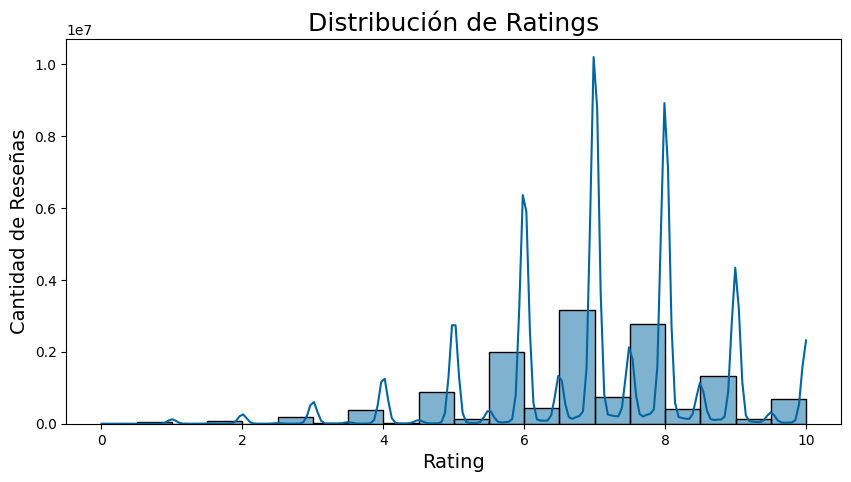

In [23]:
# Paleta de colores
plt.figure(figsize=(10, 5))
sns.histplot(data=full_data, x='rating', bins=20, kde=True, color="#0066A1")
plt.title('Distribución de Ratings', fontsize=18)
plt.xlabel('Rating', fontsize=14)
plt.ylabel('Cantidad de Reseñas', fontsize=14)
plt.show()

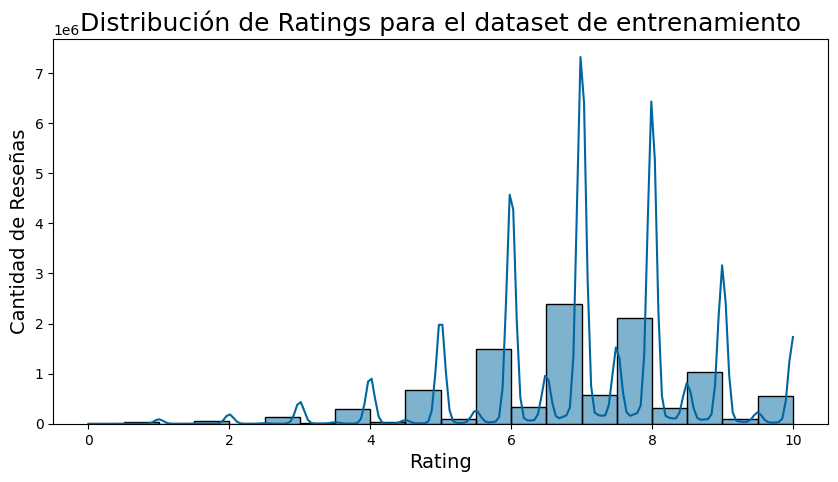

In [24]:
# Paleta de colores
plt.figure(figsize=(10, 5))
sns.histplot(data=data_tr, x='rating', bins=20, kde=True, color="#0066A1")
plt.title('Distribución de Ratings para el dataset de entrenamiento', fontsize=18)
plt.xlabel('Rating', fontsize=14)
plt.ylabel('Cantidad de Reseñas', fontsize=14)
plt.show()

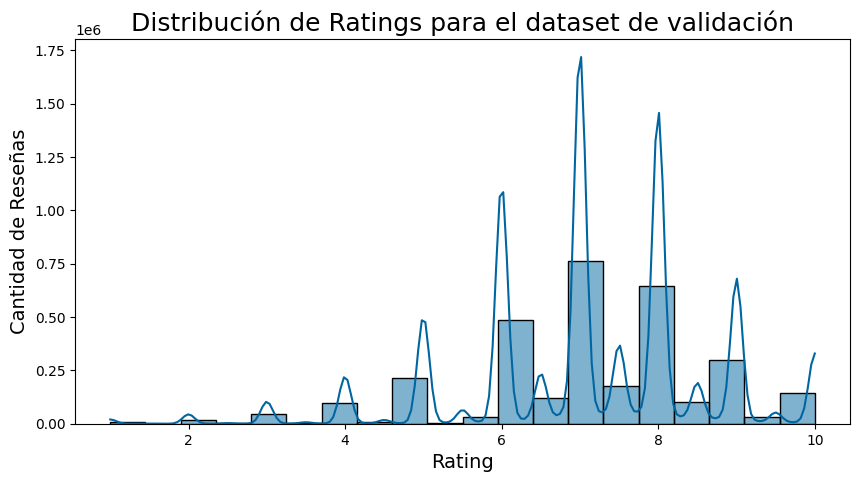

In [25]:
# Paleta de colores
plt.figure(figsize=(10, 5))
sns.histplot(data=data_val, x='rating', bins=20, kde=True, color="#0066A1")
sns.set(style="darkgrid")
plt.title('Distribución de Ratings para el dataset de validación', fontsize=18)
plt.xlabel('Rating', fontsize=14)
plt.ylabel('Cantidad de Reseñas', fontsize=14)
plt.show()

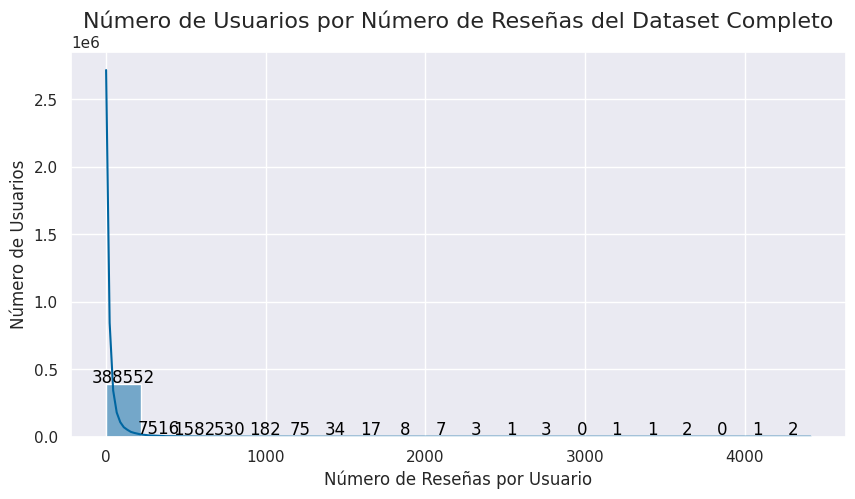

In [26]:
user_review_counts = full_data.groupby('user').size()

plt.figure(figsize=(10, 5))
ax = sns.histplot(x=user_review_counts, bins=20, kde=True, color="#0066A1")

# Agregar el número de reseñas sobre cada barra
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center',
                fontsize=12, color='black',
                xytext=(0, 5), textcoords='offset points')

plt.title('Número de Usuarios por Número de Reseñas del Dataset Completo', fontsize=16)
plt.xlabel('Número de Reseñas por Usuario', fontsize=12)
plt.ylabel('Número de Usuarios', fontsize=12)
plt.show()

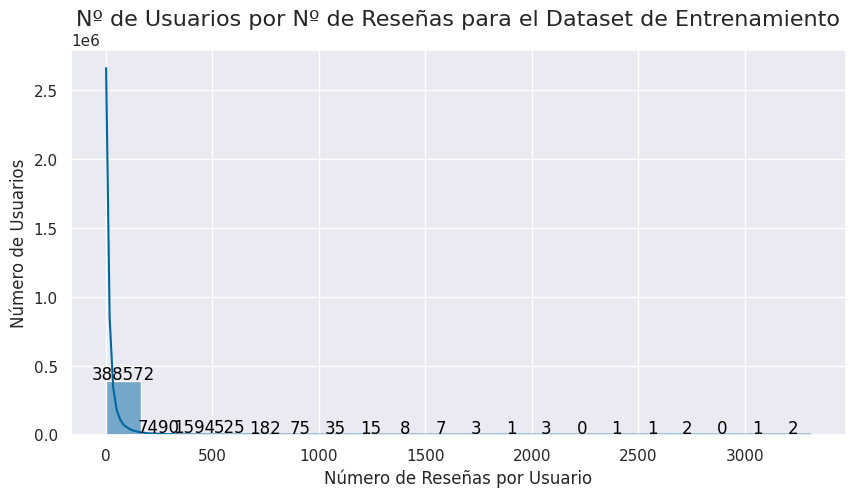

In [27]:
user_review_counts = data_tr.groupby('user').size()

plt.figure(figsize=(10, 5))
ax = sns.histplot(x=user_review_counts, bins=20, kde=True, color="#0066A1")

# Agregar el número de reseñas sobre cada barra
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center',
                fontsize=12, color='black',
                xytext=(0, 5), textcoords='offset points')

plt.title('Nº de Usuarios por Nº de Reseñas para el Dataset de Entrenamiento', fontsize=16)
plt.xlabel('Número de Reseñas por Usuario', fontsize=12)
plt.ylabel('Número de Usuarios', fontsize=12)
plt.show()

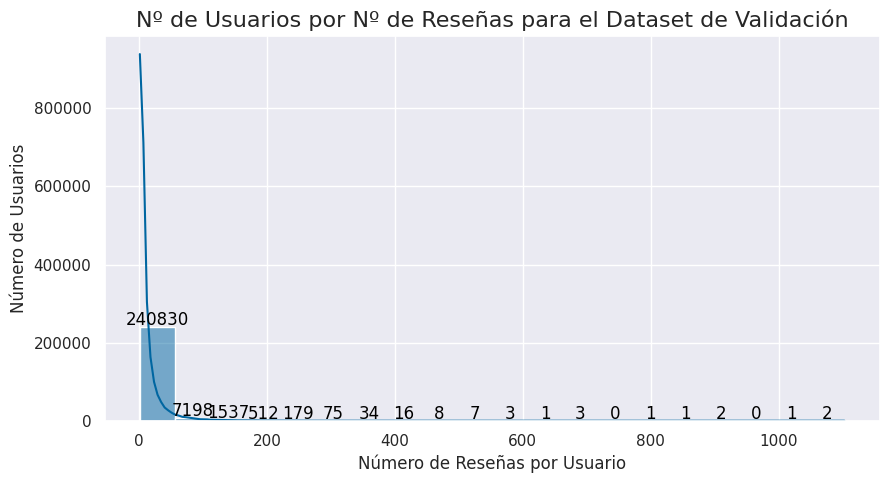

In [28]:
user_review_counts = data_val.groupby('user').size()

plt.figure(figsize=(10, 5))
ax = sns.histplot(x=user_review_counts, bins=20, kde=True, color="#0066A1")

# Agregar el número de reseñas sobre cada barra
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center',
                fontsize=12, color='black',
                xytext=(0, 5), textcoords='offset points')

plt.title('Nº de Usuarios por Nº de Reseñas para el Dataset de Validación', fontsize=16)
plt.xlabel('Número de Reseñas por Usuario', fontsize=12)
plt.ylabel('Número de Usuarios', fontsize=12)
plt.show()

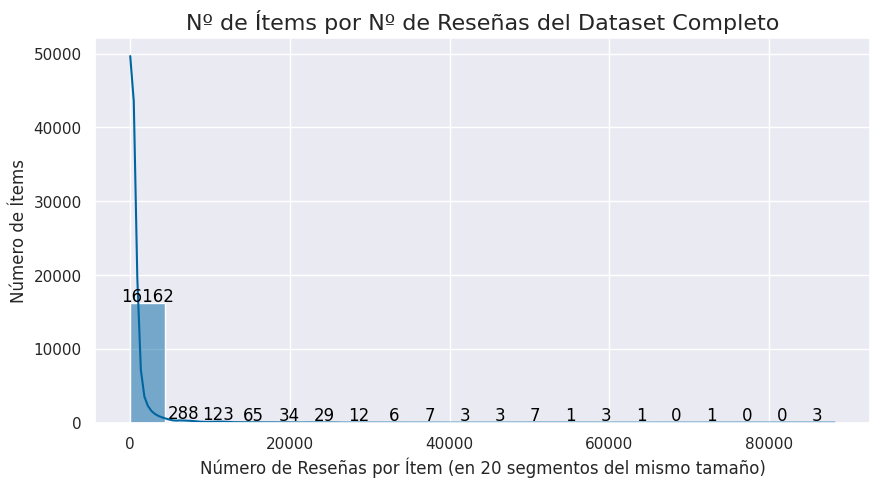

In [29]:
item_review_counts = full_data.groupby('item').size()

plt.figure(figsize=(10, 5))
ax = sns.histplot(x=item_review_counts, bins=20, kde=True, color="#0066A1")

# Agregar el número de reseñas sobre cada barra
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center',
                fontsize=12, color='black',
                xytext=(0, 5), textcoords='offset points')

plt.title('Nº de Ítems por Nº de Reseñas del Dataset Completo', fontsize=16)
plt.xlabel('Número de Reseñas por Ítem (en 20 segmentos del mismo tamaño)', fontsize=12)
plt.ylabel('Número de Ítems', fontsize=12)
plt.show()

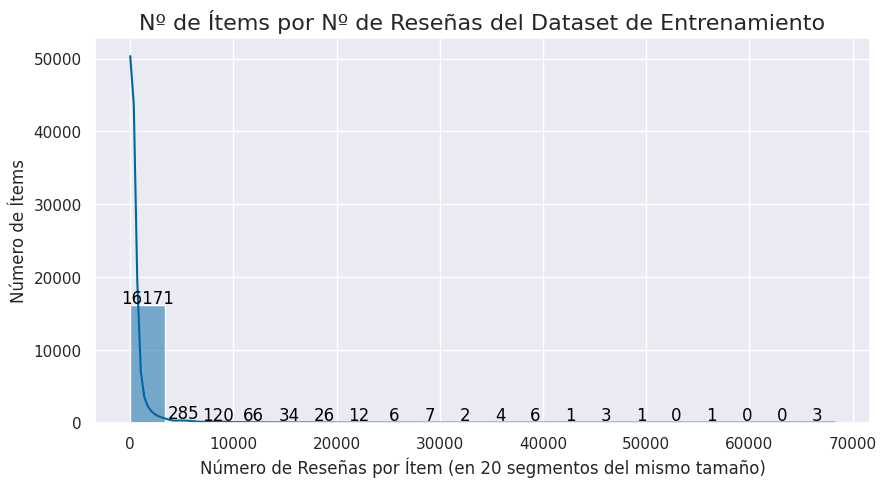

In [30]:
item_review_counts = data_tr.groupby('item').size()

plt.figure(figsize=(10, 5))
ax = sns.histplot(x=item_review_counts, bins=20, kde=True, color="#0066A1")

# Agregar el número de reseñas sobre cada barra
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center',
                fontsize=12, color='black',
                xytext=(0, 5), textcoords='offset points')

plt.title('Nº de Ítems por Nº de Reseñas del Dataset de Entrenamiento', fontsize=16)
plt.xlabel('Número de Reseñas por Ítem (en 20 segmentos del mismo tamaño)', fontsize=12)
plt.ylabel('Número de Ítems', fontsize=12)
plt.show()

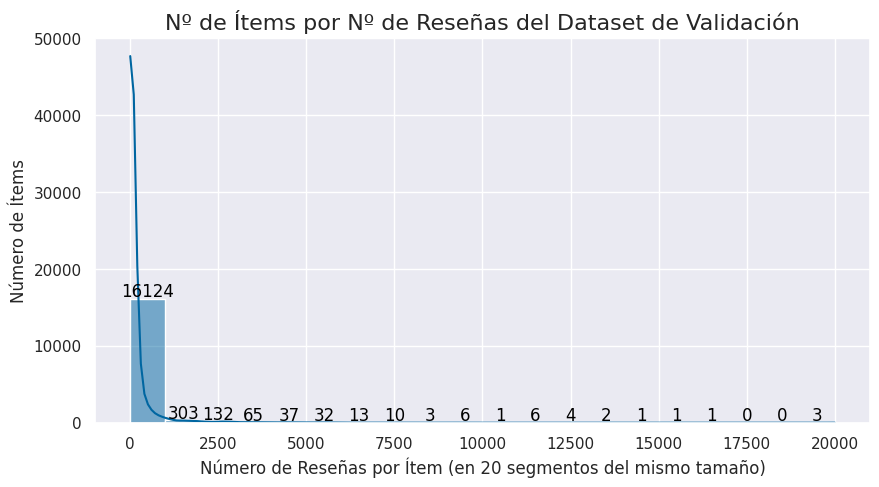

In [31]:
item_review_counts = data_val.groupby('item').size()

plt.figure(figsize=(10, 5))
ax = sns.histplot(x=item_review_counts, bins=20, kde=True, color="#0066A1")

# Agregar el número de reseñas sobre cada barra
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center',
                fontsize=12, color='black',
                xytext=(0, 5), textcoords='offset points')

plt.title('Nº de Ítems por Nº de Reseñas del Dataset de Validación', fontsize=16)
plt.xlabel('Número de Reseñas por Ítem (en 20 segmentos del mismo tamaño)', fontsize=12)
plt.ylabel('Número de Ítems', fontsize=12)
plt.show()

### Densidad del Dataset

In [32]:
# Función para calcular las estadísticas
def calculate_statistics(data):
    num_users = data['user'].nunique()  # Número de usuarios
    num_items = data['item'].nunique()  # Número de ítems
    total_ratings = len(data)  # Total de reseñas
    avg_ratings_per_user = total_ratings / num_users  # Promedio de reseñas por usuario
    avg_ratings_per_item = total_ratings / num_items  # Promedio de reseñas por ítem
    avg_rating = data['rating'].mean()  # Promedio de rating
    rating_std = data['rating'].std()  # Desviación estándar del rating
    max_ratings_by_user = data['user'].value_counts().max()  # Máximo número de reseñas por usuario
    max_ratings_for_item = data['item'].value_counts().max() # Máximo número de reseñas por ítem
    min_ratings_by_user = data['user'].value_counts().min()  # Mínimo número de reseñas por usuario
    min_ratings_for_item = data['item'].value_counts().min() # Mínimo número de reseñas por ítem
    density = (total_ratings / (num_users * num_items)) * 100  # Densidad en porcentaje

    return {
        'Número de Usuarios': num_users,
        'Número de Ítems': num_items,
        'Total de Reseñas': total_ratings,
        'Promedio de Reseñas por Usuario': avg_ratings_per_user,
        'Promedio de Reseñas por Ítem': avg_ratings_per_item,
        'Promedio de Rating': avg_rating,
        'Desviación Estándar del Rating': rating_std,
        'Máximo Número de Reseñas por un Usuario': max_ratings_by_user,
        'Máximo Número de Reseñas para un Ítem': max_ratings_for_item,
        'Mínimo Número de Reseñas por un Usuario': min_ratings_by_user,
        'Mínimo Número de Reseñas para un Ítem': min_ratings_for_item,
        'Densidad (%)': density
    }

train_stats = calculate_statistics(data_tr)
validation_stats = calculate_statistics(data_val)
full_data_stats = calculate_statistics(full_data)

# Crear DataFrame con las estadísticas
statistics = pd.DataFrame({
    'Estadística': [
        'Número de Usuarios',
        'Número de Ítems',
        'Total de Reseñas',
        'Promedio de Reseñas por Usuario',
        'Promedio de Reseñas por Ítem',
        'Promedio de Rating',
        'Desviación Estándar del Rating',
        'Máximo Número de Reseñas por un Usuario',
        'Máximo Número de Reseñas para un Ítem',
        'Mínimo Número de Reseñas por un Usuario',
        'Mínimo Número de Reseñas para un Ítem',
        'Densidad (%)'
    ],
    'Full Dataset': [
        full_data_stats['Número de Usuarios'],
        full_data_stats['Número de Ítems'],
        full_data_stats['Total de Reseñas'],
        full_data_stats['Promedio de Reseñas por Usuario'],
        full_data_stats['Promedio de Reseñas por Ítem'],
        full_data_stats['Promedio de Rating'],
        full_data_stats['Desviación Estándar del Rating'],
        full_data_stats['Máximo Número de Reseñas por un Usuario'],
        full_data_stats['Máximo Número de Reseñas para un Ítem'],
        full_data_stats['Mínimo Número de Reseñas por un Usuario'],
        full_data_stats['Mínimo Número de Reseñas para un Ítem'],
        full_data_stats['Densidad (%)']
    ],
    'Train': [
        train_stats['Número de Usuarios'],
        train_stats['Número de Ítems'],
        train_stats['Total de Reseñas'],
        train_stats['Promedio de Reseñas por Usuario'],
        train_stats['Promedio de Reseñas por Ítem'],
        train_stats['Promedio de Rating'],
        train_stats['Desviación Estándar del Rating'],
        train_stats['Máximo Número de Reseñas por un Usuario'],
        train_stats['Máximo Número de Reseñas para un Ítem'],
        train_stats['Mínimo Número de Reseñas por un Usuario'],
        train_stats['Mínimo Número de Reseñas para un Ítem'],
        train_stats['Densidad (%)']
    ],
    'Validation': [
        validation_stats['Número de Usuarios'],
        validation_stats['Número de Ítems'],
        validation_stats['Total de Reseñas'],
        validation_stats['Promedio de Reseñas por Usuario'],
        validation_stats['Promedio de Reseñas por Ítem'],
        validation_stats['Promedio de Rating'],
        validation_stats['Desviación Estándar del Rating'],
        validation_stats['Máximo Número de Reseñas por un Usuario'],
        validation_stats['Máximo Número de Reseñas para un Ítem'],
        validation_stats['Mínimo Número de Reseñas por un Usuario'],
        validation_stats['Mínimo Número de Reseñas para un Ítem'],
        validation_stats['Densidad (%)']
    ]
})

# Exportar la tabla a un archivo excel
statistics.round(2).to_excel('estadisticas_dataset.xlsx', index=False)

# Mostrar tabla
statistics.round(2)

,Estadística,Full Dataset,Train,Validation
0,Número de Usuarios,398517.00,398517.00,250410.00
1,Número de Ítems,16748.00,16748.00,16744.00
2,Total de Reseñas,13414601.00,10200445.00,3202256.00
3,Promedio de Reseñas por Usuario,33.66,25.60,12.79
4,Promedio de Reseñas por Ítem,800.97,609.05,191.25
5,Promedio de Rating,7.14,7.15,7.10
6,Desviación Estándar del Rating,1.54,1.54,1.53
7,Máximo Número de Reseñas por un Usuario,4413.00,3310.00,1103.00
8,Máximo Número de Reseñas para un Ítem,88254.00,68263.00,20001.00
9,Mínimo Número de Reseñas por un Usuario,1.00,1.00,1.00


Más adelante podría ser importante analizar items que tengan muchas calificaciones o usuarios que hayan hecho muchas calificaciones. Esto ya que nos interesa hacer recomendaciones grupales y necesitamos un ground truth. Sería importante agrupar usuarios que probablemente hayan calificado al mismo juego (porque han calificado mucho y encontraremos un juego en común) o seleccionar items que se hayan calificado mucho (encontraremos usuarios en común).

In [33]:
# Contar cuántas calificaciones tiene cada ítem
top_items = (
    df_user_ratings.groupby("item")
    .size()
    .reset_index(name="num_ratings")
    .sort_values("num_ratings", ascending=False)
    .head(20)
)

top_items


,item,num_ratings
5382,30549,107760
566,822,107601
11,13,106725
6834,68448,89014
5798,36218,80901
3220,9209,75352
10808,178900,73188
10175,167791,72753
5426,31260,65637
1708,3076,64925


In [34]:
# Contar cuántas calificaciones tiene cada usuario
top_users = (
    df_user_ratings.groupby("user")
    .size()
    .reset_index(name="num_ratings")
    .sort_values("num_ratings", ascending=False)
    .head(20)
)

top_users


,user,num_ratings
389011,warta,5516
335191,oldgoat3769967,5254
189209,TomVasel,5036
78137,Hessu68,4592
306499,leffe dubbel,4577
48584,Doel,4347
262015,fake,3991
189032,Tolkana,3581
198744,Walt Mulder,3539
17617,Be4tngU,3323
